In [1]:
!pip install -q torch torchvision torchaudio
!pip install -q scikit-plot


In [3]:
!pip install scipy==1.13.1 --quiet

  error: subprocess-exited-with-error
  
  Preparing metadata (pyproject.toml) did not run successfully.
  exit code: 1
  
  [22 lines of output]
  + meson setup C:\Users\anasm\AppData\Local\Temp\pip-install-ae6yg1s9\scipy_cbcd78c67a6f48579f311a017fe00996 C:\Users\anasm\AppData\Local\Temp\pip-install-ae6yg1s9\scipy_cbcd78c67a6f48579f311a017fe00996\.mesonpy-37niobgp -Dbuildtype=release -Db_ndebug=if-release -Db_vscrt=md --native-file=C:\Users\anasm\AppData\Local\Temp\pip-install-ae6yg1s9\scipy_cbcd78c67a6f48579f311a017fe00996\.mesonpy-37niobgp\meson-python-native-file.ini
  The Meson build system
  Version: 1.9.1
  Source dir: C:\Users\anasm\AppData\Local\Temp\pip-install-ae6yg1s9\scipy_cbcd78c67a6f48579f311a017fe00996
  Build dir: C:\Users\anasm\AppData\Local\Temp\pip-install-ae6yg1s9\scipy_cbcd78c67a6f48579f311a017fe00996\.mesonpy-37niobgp
  Build type: native build
  Project name: scipy
  Project version: 1.13.1
  C compiler for the host machine: gcc (gcc 6.3.0 "gcc (MinGW.org GCC-6.

In [19]:

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms

import os
import cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [20]:
def extract_frames(video_path, frame_rate=1):
    cap = cv2.VideoCapture(video_path)
    frames = []
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    step = max(int(fps/frame_rate), 1)
    
    for i in range(0, total_frames, step):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = cv2.resize(frame, (48,48))
        frames.append(frame)
    cap.release()
    return frames, fps

def parse_gt(gt_file):
    cheats = []
    with open(gt_file, 'r') as f:
        
        for line in f.readlines():
            parts = line.strip().split()
            if len(parts) >= 3:
                start, end, _type = float(parts[0]), float(parts[1]), parts[2]
                cheats.append((start, end, _type))
    return cheats


In [26]:
class OEPDataset(Dataset):
    def __init__(self, root_dir, subjects, transform=None, frame_rate=1):
        self.data = []
        self.transform = transform

        for subject in subjects:
            folder = os.path.join(root_dir, subject)
            gt_file = os.path.join(folder, 'gt.txt')
            
            if not os.path.isfile(gt_file):
                print(f"Skipping {folder}, gt.txt not found")
                continue

            cheats = parse_gt(gt_file)

            webcam_files = [f for f in os.listdir(folder) if f.endswith('1.avi')]
            for vf in webcam_files:
                video_path = os.path.join(folder, vf)
                frames, fps = extract_frames(video_path, frame_rate)
                
                for idx, frame in enumerate(frames):
                    time_sec = idx / fps


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frame, label = self.data[idx]
        if self.transform:
            frame = self.transform(frame)
        return frame, label


In [27]:
data_path = 'OEP database'  
all_subjects = sorted(os.listdir(data_path))
print("All subjects:", all_subjects)

acting_subjects = [s for s in all_subjects if s in ['subject1','subject2','subject3','subject4','subject5','subject6','subject7','subject8','subject9','subject17','subject20','subject21','subject22','subject23','subject24']]
real_subjects = [s for s in all_subjects if s not in acting_subjects]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = OEPDataset(data_path, acting_subjects, transform=transform, frame_rate=1)
test_dataset  = OEPDataset(data_path, real_subjects, transform=transform, frame_rate=1)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


All subjects: ['.ipynb_checkpoints', 'subject1', 'subject10', 'subject11', 'subject12', 'subject13', 'subject14', 'subject15', 'subject16', 'subject17', 'subject18', 'subject19', 'subject2', 'subject20', 'subject21', 'subject22', 'subject23', 'subject24', 'subject3', 'subject4', 'subject5', 'subject6', 'subject7', 'subject8', 'subject9']
Skipping OEP database\.ipynb_checkpoints, gt.txt not found
Train samples: 14242
Test samples: 10911


In [28]:
class CheatingCNN(nn.Module):
    def __init__(self):
        super(CheatingCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64*12*12, 1024)
        self.dropout = nn.Dropout(0.25)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64*12*12)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CheatingCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [29]:
epochs = 10  

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    
    for frames, labels in train_loader:
        frames, labels = frames.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(frames)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(train_loader):.4f} - Accuracy: {acc:.4f}")


Epoch 1/10 - Loss: 0.1715 - Accuracy: 0.9406
Epoch 2/10 - Loss: 0.1078 - Accuracy: 0.9591
Epoch 3/10 - Loss: 0.0801 - Accuracy: 0.9694
Epoch 4/10 - Loss: 0.0578 - Accuracy: 0.9778
Epoch 5/10 - Loss: 0.0518 - Accuracy: 0.9797
Epoch 6/10 - Loss: 0.0383 - Accuracy: 0.9848
Epoch 7/10 - Loss: 0.0346 - Accuracy: 0.9868
Epoch 8/10 - Loss: 0.0266 - Accuracy: 0.9915
Epoch 9/10 - Loss: 0.0237 - Accuracy: 0.9924
Epoch 10/10 - Loss: 0.0197 - Accuracy: 0.9926


In [30]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for frames, labels in test_loader:
        frames, labels = frames.to(device), labels.to(device)
        outputs = model(frames)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print("Test Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Test Accuracy: 0.7161580056823389
Precision: 0.2099236641221374
Recall: 0.01867572156196944
F1-score: 0.034299968818210166


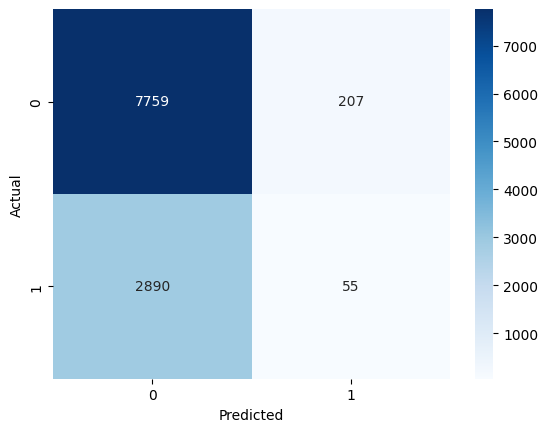

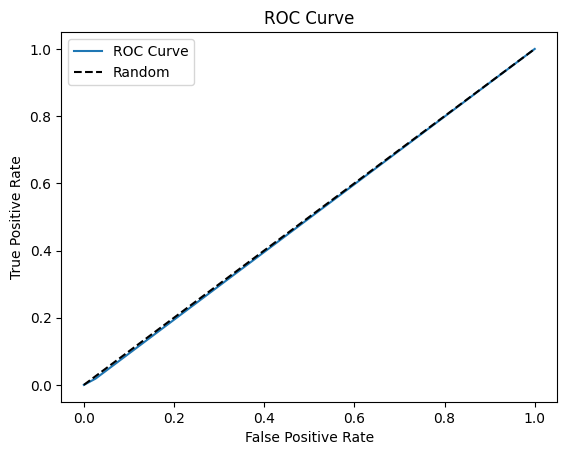

In [31]:

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1], [0,1], 'k--', label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")8ipbg0t00
plt.legend()
plt.show()
